# Evaluating Synthetic dataset

In [1]:
from his.rcnn_utils import *
import his.metrics
import his.models as crnn
from torchvision.transforms import v2
from torch.nn import init
from collections import namedtuple
import torchvision.transforms.functional as TF
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from itertools import product
from discordwebhook import Discord

## Datasets:

- RP500, RP1000
- RT500, RT1000
- PP500, PP1000
- PT500, PP1000

In [2]:
def load_and_split(loader: Dataset, split: list, seed: torch.Generator) -> Data:
    return Data(*random_split(
        loader,
        split,
        seed
    )[:3])

In [3]:
# dataset class
Dataset = namedtuple("Dataset", ["name", "train", "val", "test"])

# datasets 
dRP500 = load_and_split(
    BaseRcnnDataset("../data/DRect_plain_1000/data/", "../data/DRect_plain_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )
dRP500 = Dataset("dRP500", dRP500.train, dRP500.val, dRP500.test)

dRP1000 = load_and_split(
    BaseRcnnDataset("../data/DRect_plain_1000/data/", "../data/DRect_plain_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )
dRP1000 = Dataset("dRP1000", dRP1000.train, dRP1000.val, dRP1000.test)

dRT500 = load_and_split(
    BaseRcnnDataset("../data/DRect_texture_1000/data/", "../data/DRect_texture_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )
dRT500 = Dataset("dRT500", dRT500.train, dRT500.val, dRT500.test)

dRT1000 = load_and_split(
    BaseRcnnDataset("../data/DRect_texture_1000/data/", "../data/DRect_texture_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )
dRT1000 = Dataset("dRT1000", dRT1000.train, dRT1000.val, dRT1000.test)

dPP500 = load_and_split(
    BaseRcnnDataset("../data/DPoly_plain_1000/data/", "../data/DPoly_plain_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )
dPP500 = Dataset("dPP500", dPP500.train, dPP500.val, dPP500.test)

dPP1000 = load_and_split(
    BaseRcnnDataset("../data/DPoly_plain_1000/data/", "../data/DPoly_plain_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )
dPP1000 = Dataset("dPP1000", dPP1000.train, dPP1000.val, dPP1000.test)

dPT500 = load_and_split(
    BaseRcnnDataset("../data/DPoly_texture_1000/data/", "../data/DPoly_texture_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )
dPT500 = Dataset("dPT500", dPT500.train, dPT500.val, dPT500.test)

dPT1000 = load_and_split(
    BaseRcnnDataset("../data/DPoly_texture_1000/data/", "../data/DPoly_texture_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )
dPT1000 = Dataset("dPT1000", dPT1000.train, dPT1000.val, dPT1000.test)

DATASETS = [
    dRP500, dRP1000,
    dRT500, dRT1000,
    dPP500, dPP1000,
    dPT500, dPT1000
]

## Models

Base cells:
- RNN-cell
- LSTM-cell
- GRU-cell

Variants:
- 2 Convolutional Layers
- SegNet
- UNet

$3\times 3 = 9$ combinations




## Base cells

- 2 Convolutiona layers
- SegNet
- UNet

In [4]:
class Conv2Layers(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        )
        
        init.orthogonal_(self.process[0].weight)
        init.orthogonal_(self.process[-1].weight)
        
    def forward(self, x):
        return self.process(x)
    

In [5]:
SegNet = lambda x, y: nn.Sequential(
    nn.Conv2d(x, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    
    nn.ConvTranspose2d(128, 64, 2, 2),
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.ConvTranspose2d(64, 32, 2, 2),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, y, 3, 1, 1),
)

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), # no bias for batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3, 
        out_channels=1,
        features=[64, 128, 256, 512],
        dropout=0.,
        DoubleConv = DoubleConv
    ):
        super().__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = dropout
        
        # downs
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # ups
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    2,
                    2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            x = nn.functional.dropout2d(x, self.dropout)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            x = nn.functional.dropout2d(x, self.dropout)
            
        return self.final_conv(x)
    
    def grad_norm(self):
        total_norm = 0.0
        for param in self.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

        return total_norm

In [7]:
Model = namedtuple('Model', ['name', 'init'])

MODELS = [
    Model('RNN-2C', lambda: crnn.ConvRNNCell(3, 200, 200, Conv2Layers)),
    Model('RNN-SegNet', lambda: crnn.ConvRNNCell(3, 200, 200, SegNet)),
    Model('RNN-UNet', lambda: crnn.ConvRNNCell(3, 200, 200, UNet)),
    
    Model('LSTM-2C', lambda: crnn.ConvLSTMCell(3, 200, 200, Conv2Layers)),
    Model('LSTM-SegNet', lambda: crnn.ConvLSTMCell(3, 200, 200, SegNet)),
    Model('LSTM-UNet', lambda: crnn.ConvLSTMCell(3, 200, 200, UNet)),
    
    Model('GRU-2C', lambda: crnn.ConvGRUCell(3, 200, 200, Conv2Layers)),
    Model('GRU-SegNet', lambda: crnn.ConvGRUCell(3, 200, 200, SegNet)),
    Model('GRU-UNet', lambda: crnn.ConvGRUCell(3, 200, 200, UNet)),
]

## Train utils

In [8]:
def iou(prediction, target, threshold=0.5, smooth=1e-5, norm=1):
    prediction_binary = (prediction > threshold).float()
    
    target /= norm
    intersection = torch.sum(prediction_binary * target)
    union = prediction_binary + target
    union[union > 1] = 1
    union = torch.sum(union)

    dice = (intersection + smooth) / (union + smooth)
    return dice.cpu().detach()

def iou_score(model, dataset, threshold=0.5, device="cuda", norm=1):
    score_sum = 0
    count = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]
            model.resetState()
                
            prediction = model(input.unsqueeze(dim=0))
            
            for t in target:
                score_sum += float(iou(prediction.squeeze(), t/norm, threshold))
                prediction = model(input.unsqueeze(dim=0))
                count += 1
                
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/count

def binary_dice_coefficient(prediction, target, threshold=0.5, smooth=1e-5):
    prediction_binary = (prediction > threshold).float()
    
    intersection = torch.sum(prediction_binary * target)
    union = torch.sum(prediction_binary) + torch.sum(target)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.cpu().detach()


def dice_score(model, dataset, threshold=0.5, device="cuda", norm=1):
    score_sum = 0
    count = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]
            
            model.resetState()
            
            prediction = model(input.unsqueeze(dim=0))
            
            for t in target:
                score_sum += float(binary_dice_coefficient(prediction.squeeze(), t/norm, threshold))
                prediction = model(input.unsqueeze(dim=0))
                count += 1
            
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/count


In [9]:
def train(
    dataset: Data, 
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer, 
    loss: torch.nn.Module, 
    writer: SummaryWriter,
    n_epochs: tuple=(0, 50),
    device: str="cuda",
    dice: bool=False,
    norm: float=1.0,
    log: Discord=None):
    
    for epoch in range(*n_epochs):
        epoch_loss = 0
        for data in dataset.train:
            # reset hidden state
            model.resetState()
            
            image, annotation = data
            image = image.to(device).unsqueeze(dim=0)
            
            optimizer.zero_grad()
            
            output = model(image)
            
            l = 0
        
            for weight, ann in enumerate(annotation):
                ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0).float()/norm
                l += loss(output, ann)
                # next step input                
                output = model(image)
            
            l.backward()
            
            optimizer.step()
        
            epoch_loss += float(l)
            
        epoch_loss /= len(dataset.train)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch {epoch}: {epoch_loss}")
            
        # val
        with torch.inference_mode():
            val_loss = 0
            for data in dataset.val:
                # reset hidden state
                model.resetState()
                
                image, annotation = data
                image = image.to(device).unsqueeze(dim=0)
                
                output = model(image)
                
                l = 0
            
                for weight, ann in enumerate(annotation):
                    ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0).float()/norm
                    l += loss(output, ann)
                    # next step input                
                    output = model(image)
                    
                val_loss += float(l)
                
            val_loss /= len(dataset.val)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("GradNorm", model.grad_norm(), epoch)
            
            if log and epoch%50==0:
                log.post(content=f"Train loss: {float(epoch_loss)}, Val loss:{float(val_loss)}")
            
    if not dice:
        return
    
    dices = []
    ious = []
    for i, thresh in enumerate(np.arange(0, 1.1, 0.1)):
        train_dice = dice_score(model, dataset.train, thresh)
        val_dice = dice_score(model, dataset.val, thresh)
        writer.add_scalar("Dice/train", train_dice, i)
        writer.add_scalar("Dice/val", val_dice, i)
        dices.append(train_dice)
        
        train_iou = iou_score(model, dataset.train, thresh)
        val_iou = iou_score(model, dataset.val, thresh)
        writer.add_scalar("IoU/train", train_iou, i)
        writer.add_scalar("IoU/val", val_iou, i)
        ious.append(train_iou)
        
    return dices, ious
            
def n_params(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [10]:
def show_results(model, dataset, idx, in_channels=3, height=200, width=200):
    with torch.inference_mode():
        image, annotation = dataset[idx]
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 7, 1)
        plt.imshow(image.permute(1,2,0))
        plt.axis("off")
        
        image = (image).unsqueeze(dim=0).to("cuda")
        
        model.hidden = torch.ones(1, in_channels, height, width).to("cuda")
        for i in range(5):
            plt.subplot(1, 7, i+2)
            output = model(image)
            
            plt.imshow(output.detach().cpu().squeeze())
            # plt.imshow(annotation[i])
            plt.axis("off")
            
        plt.savefig("fig.png")
        plt.close()

## Training loop

In [11]:
log = Discord(url="https://discord.com/api/webhooks/1219933822351577088/Gz4O9UZlnG7QBGTb9v5wPKlzxO3N8y_r9efsjFMOuHRki_Ok0Xw7e47P2eLt0A7DeA11")

In [2]:
def hierarchy_score(model, dataset, threshold=0.5, device="cuda", norm=1):
    precision = 0
    recall = 0
    f1 = 0
    count = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]
            
            model.resetState()
            
            prediction = model(input.unsqueeze(dim=0))
            
            for t in target:
                t_in = t.cpu().numpy()
                pred_in = prediction.squeeze().cpu().numpy() >= threshold
                
                his_metrics = his.metrics.hierarchical_metrics(t_in, pred_in)
                precision += his_metrics["precision"]
                recall += his_metrics["recall"]
                f1 += his_metrics["f1"]
                prediction = model(input.unsqueeze(dim=0))
                count += 1
            
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return precision/count, recall/count, f1/count

In [3]:
import datetime

def get_datetime():
    return datetime.datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")

In [14]:
n_epochs = 1

# get combination of datasets and models
for i, (model_def, dataset) in enumerate(product(MODELS, DATASETS)):
    
    # initialize model trainers
    # -------log-----------
    # log.post(content=f"Training model {model_def.name}, {dataset.name} {get_datetime()}⭐")
    # -------log-----------
    
    model = model_def.init().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
    writer = SummaryWriter(f"./runs/{model_def.name}_{dataset.name}", comment="BCE_pos=4.0")
    
    # training
    dices, ious = train(dataset,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, n_epochs),
      dice=True,
      log=log)
    
    size = dataset.val[0][1][0].shape[0]
    show_results(model, dataset.val, 10, height=size, width=size)
    # -------log-----------
    # with open("fig.png", "rb") as f:
    #   log.post(content=f"Result of {model_def.name} on {dataset.name}", file={
    #     "output.png": f
    #   })
    # -------log-----------
    
    # computing hierarchy metrics for scores
    # threshold = np.argmax(ious)/10
    # h_train = hierarchy_score(model, dataset.train, threshold)
    # h_val = hierarchy_score(model, dataset.val, threshold)
    # writer.add_scalar("HIS/Precision/train", h_train[0])
    # writer.add_scalar("HIS/Recall/train", h_train[1])
    # writer.add_scalar("HIS/F1/train", h_train[2])
    # writer.add_scalar("HIS/Precision/val", h_val[0])
    # writer.add_scalar("HIS/Recall/val", h_val[1])
    # writer.add_scalar("HIS/F1/train", h_val[2])
    
    # -------log-----------
    # log.post(content=f"Training:\n Precision: {h_train[0]}, Recall: {h_train[1]}, F1: {h_train[2]}")
    # log.post(content=f"Validation:\n Precision: {h_val[0]}, Recall: {h_val[1]}, F1: {h_val[2]}")
    # log.post(content=f"Training finished {get_datetime()} ✅")
    # -------log-----------
    print(f"fin {model_def.name}, {dataset.name}")
    break

Epoch 0: 3.569179330468178
fin RNN-2C, dRP500


In [111]:

# %%
import numpy as np
from typing import List, Tuple, Callable
import pickle
import matplotlib.pyplot as plt
import itertools

# %%
def find_seed(matrix: np.ndarray) -> Tuple[int, int]:
    """finds first non-zero entry in the matrix

    Args:
        matrix (np.ndarray): 2-D matrix of binary non overlapping regions

    Returns:
        Tuple[int, int]: index of first non-zero entry
    """
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 1:
                return i, j

# %%
def flood(mask: np.ndarray, 
          seed_x: int,
          seed_y: int,
          value: int = 2) -> None:
    """flood fills the area for given seed

    Args:
        mask (np.ndarray): 2-D matrix with regions
        seed_x (int): x index of seed
        seed_y (int): y index of seed
        value (int, optional): fill value. Defaults to 2.
    """
    flood_area = mask[seed_x, seed_y]
    fill_pixels = [(seed_x, seed_y)]
    
    # track visited pixels
    filled = np.zeros_like(mask)
    filled[seed_x, seed_y] = 1
    
    def is_valid(i, j):
        return (i >= 0
                and j >= 0
                and i < mask.shape[0]
                and j < mask.shape[1])
    
    while fill_pixels:
        x, y = fill_pixels.pop()    
        mask[x, y] = value
        
        for dx, dy in itertools.product([0,1,-1], [0, 1, -1]):
            if (is_valid(x+dx, y+dy) 
                and mask[x+dx, y+dy] == flood_area 
                and filled[x+dx, y+dy] == 0):
                fill_pixels.append((x+dx, y+dy))
                filled[x+dx, y+dy] = 1
                    

# %%
def flood_fill(mask: np.ndarray) -> int:
    index = find_seed(mask)
    mask_counter = 2
    while index:
        flood(mask, index[0], index[1], mask_counter)
        index = find_seed(mask)
        mask_counter += 1
    return mask, mask_counter-2

# %%
def binary_mask_to_children(mask: np.ndarray) -> List[np.ndarray]:
    """Converts a compund binary mask to list of individual masks

    Args:
        mask (torch.tensor): binary mask of objects
    """
    
    mask, n_children = flood_fill(mask.copy())
        
    children = []
    for i in range(n_children):
        children.append(mask == i+2)
        
    return children

# %%
class Tree:
    def __init__(self, data, level=0):
        self.data = data
        self.level = level
        self.entropy = 1
        self.children: List[Tree] = []
        self.match = None
        
    def traverse_inorder(self, func: Callable=lambda x, l: print("  "*l, x.data)):
        func(self, self.level)
        for child in self.children:
            child.traverse_inorder(func)
            
    def _assign_r_entropy(self, entropy=1):
        self.entropy = (2*entropy)/(len(self.children)+2) if len(self.children) else entropy
        for child in self.children:
            child._assign_r_entropy(entropy/(len(self.children)+2))
            
    def assign_entropy(self):
        self._assign_r_entropy()
        def reciprocal(x, l):
            x.entropy = 1/x.entropy
            
        self.traverse_inorder(reciprocal)
        
    def total_entropy(self):
        total = 0
        def get_total(x, l):
            nonlocal total
            total += x.entropy
            
        self.traverse_inorder(get_total)
        return total
    
    def copy(self):
        root = Tree(self.data, self.level)
        
        for child in self.children:
            root.children.append(child.copy())
        
        return root
    
    def find_matching(self, masks: np.ndarray, threshold=0.9) -> "Tree":
        tree = self.copy()
        
        def matcher(x, l):
            for m in masks:
                if np.sum(x.data & m) / np.sum(x.data | m) >= threshold:
                    x.match = True
                    
        tree.traverse_inorder(matcher)
        return tree
    
    def _flat_list(self) -> List["Tree"]:
        children = []
        for child in self.children:
            if child.match == True:
                children.append(child)
            else:
                children.extend(child._flat_list())
                
        return children
        
        
    def prune(self, level=0):
        root = Tree(self.data, level)
        children = self._flat_list()
        
        for child in children:
            root.children.append(child.prune(level+1))
            
        return root
        
# %%
def is_contained(parent: np.ndarray, child: np.ndarray):
    return np.all((parent & child) == child)

# %%
def _generate_tree(root: Tree, mask_groups: dict):
    if root.level + 1 > len(mask_groups):
        return
    
    for mask in mask_groups[root.level+1]:
        if is_contained(root.data, mask):
            root.children.append(Tree(mask, root.level+1))
            
    for child in root.children:
        _generate_tree(child, mask_groups)

# %%
def generate_mask_tree(masks: List[np.ndarray]) -> Tree:
    root = Tree(np.ones(masks[0].shape, dtype=bool))
    mask_groups = {i+1: binary_mask_to_children(mask) for i, mask in enumerate(masks)}
    
    # generate mask hierarchy tree
    _generate_tree(root, mask_groups)
    
    return root

# %%
def get_mask_list(masks: List[np.ndarray]) -> List[np.ndarray]:
    mask_list = []
    for mask in masks:
        mask_list.extend(binary_mask_to_children(mask))
        
    return mask_list

# %%
def hierarchical_metrics(truth: List[np.ndarray], pred: List[np.ndarray]) -> dict:
    
    print(f"truth: {len(truth)}, pred: {len(pred)}")
    
    # ground truth tree
    gt_tree = generate_mask_tree(truth)
    
    print(f"generated gt tree")
    
    # prediction list
    pred_tree = generate_mask_tree(pred)
    print(f"generated pred tree")
    
    preds = get_mask_list(pred)
    
    # get matching tree
    pruned_tree = gt_tree.find_matching(preds).prune()
    
    # assign entropy
    gt_tree.assign_entropy()
    pred_tree.assign_entropy()
    pruned_tree.assign_entropy()
    
    gt_tree.traverse_inorder(lambda x, l: print("  "*l, x.entropy))
    pred_tree.traverse_inorder(lambda x, l: print("  "*l, x.entropy))
    pruned_tree.traverse_inorder(lambda x, l: print("  "*l, x.entropy))
    
    # compute entropy
    gt_e = gt_tree.total_entropy()
    pred_e = pred_tree.total_entropy()
    pruned_e = pruned_tree.total_entropy()
    
    # precision, recall , f1
    precision = pruned_e / pred_e
    recall = pruned_e / gt_e
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return {
        "hierarchical-precision": precision,
        "hierarchical-recall": recall,
        "hierarchical-f1": f1
    }

def hierarchy_score(model, dataset, threshold=0.5, device="cuda", norm=1):
    precision = 0
    recall = 0
    f1 = 0
    count = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]
            
            model.resetState()
            
            prediction = model(input.unsqueeze(dim=0))
            t_in = []
            pred_in = []
            for t in target[:-1]:
                t_in.append(t.cpu().numpy())
                pred_in.append((prediction.squeeze().cpu().numpy() >= threshold).astype(int))
                prediction = model(input.unsqueeze(dim=0))
                count += 1
                
            his_metrics = hierarchical_metrics(t_in, pred_in)
            precision += his_metrics["hierarchical-precision"]
            recall += his_metrics["hierarchical-recall"]
            f1 += his_metrics["hierarchical-f1"]
            
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return precision/count, recall/count, f1/count

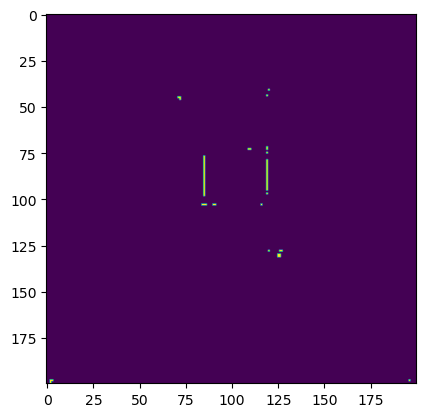

In [87]:
plt.imshow(i1==1)

In [113]:
generate_mask_tree(ops).traverse_inorder(lambda x, y: print(" "*y, x))

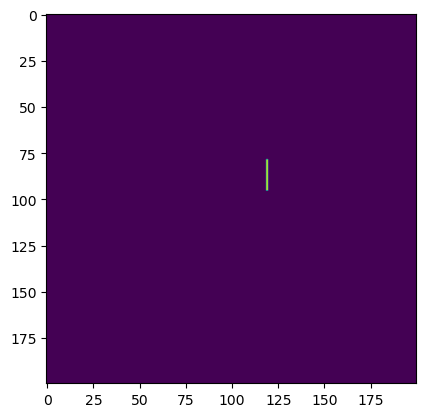

In [99]:
plt.imshow(i1==10)

In [72]:
# getting some layer of outputs
import pickle
model.resetState()

with torch.inference_mode():
    image, target = dRP500.train[0]
    output1 = model(image.unsqueeze(dim=0).cuda())
    output2 = model(image.unsqueeze(dim=0).cuda())
    output3 = model(image.unsqueeze(dim=0).cuda())
    
plt.imshow(output1.cpu().squeeze() > 0.1)
with open("dummy_op.pkl", "wb") as f:
    pickle.dump([o.cpu().squeeze().numpy() > 0.1 for o in [output1, output2, output3]], f)

NameError: name 'model' is not defined

In [109]:
import pickle
with open("dummy_op.pkl", "rb") as r:
    ops = pickle.load(r)
    ops = [o.astype(int) for o in ops]
    
i1 = ops[0]

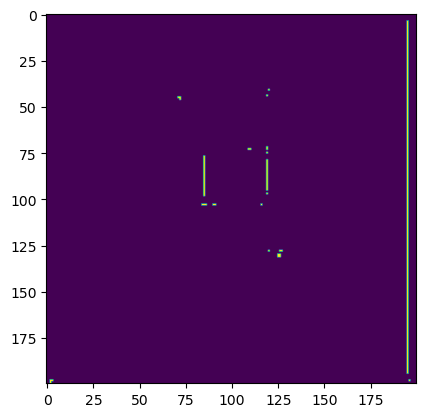

In [108]:
plt.imshow(i1)

In [80]:
i1 = ops[0].astype(int)

In [82]:
h_train = hierarchy_score(model, dataset.train, threshold)

truth: 3, pred: 3
mask group generated
generated gt tree


KeyboardInterrupt: 